In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA


In [2]:

data = pd.read_csv('data/EVChargingStationUsage.csv')

C:\Users\pgsva\AppData\Local\Temp\ipykernel_9052\2002277991.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EVChargingStationUsage.csv')


In [3]:
#function to extract the entity based on the first word following "PALO ALTO CA /"
def extract_entity(station_name):
    parts = station_name.split('/')
    if len(parts) > 1:
        # Take the part after "PALO ALTO CA /" and then take the first word
        return parts[1].strip().split(' ')[0]
    else:
        # If the station name does not follow the expected format, return the original
        return station_name

# Function to create lagged features
def buildLaggedFeatures(s, lag=30, dropna=True):
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df


In [4]:
data["Normalized Station Name"] = data["Station Name"].str.split(pat=" / | #| [0-9]").apply(lambda col: col[1])
data = data.dropna(subset=['Normalized Station Name'])

In [5]:
stations = data['Normalized Station Name'].unique()

In [6]:
data.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number,Normalized Station Name
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN,HAMILTON
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN,HAMILTON
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN,HAMILTON
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN,HAMILTON
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN,HAMILTON


In [7]:
def secondTransform(x: str) -> int:
    h, m, s = x.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

data["Total Duration s"] = data["Total Duration (hh:mm:ss)"].apply(lambda x: secondTransform(x))
data["Charging Time s"] = data["Charging Time (hh:mm:ss)"].apply(lambda x: secondTransform(x))
data["Idle Time s"] = data['Total Duration s']-data["Charging Time s"]


In [8]:
data["Transaction Date (Pacific Time)"] = pd.to_datetime(data["Transaction Date (Pacific Time)"], format="%m/%d/%Y %H:%M", errors='coerce')
data.dropna(subset=['Transaction Date (Pacific Time)'], inplace=True)

In [9]:
piv_data = pd.pivot_table(data, values="Energy (kWh)", index="Transaction Date (Pacific Time)", columns= "Normalized Station Name", aggfunc=np.sum, fill_value=0)
piv_data.reset_index(inplace=True)

In [10]:
df = piv_data.assign(timestamp=pd.to_datetime(piv_data["Transaction Date (Pacific Time)"]).dt.date).groupby('timestamp', as_index=False).sum()

C:\Users\pgsva\AppData\Local\Temp\ipykernel_9052\1069757748.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = piv_data.assign(timestamp=pd.to_datetime(piv_data["Transaction Date (Pacific Time)"]).dt.date).groupby('timestamp', as_index=False).sum()


In [11]:
# Training data split
train_df = df.iloc[:-30]  
test_df = df.iloc[-30:]

In [12]:
model = pm.auto_arima(train_df["HAMILTON"], seasonal=True, start_p=0, start_q=0, max_p=15, max_q=15, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34402.789, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33665.912, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32640.865, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34400.789, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32617.529, Time=1.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32618.308, Time=2.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32644.473, Time=2.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32617.125, Time=1.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32619.060, Time=3.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32621.084, Time=4.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32615.139, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32638.880, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32642.488, Time=1.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=32617.074, Time=1.26 sec
 ARIMA(1,1,1)(0,0,0

In [13]:
forecast_df = pd.DataFrame(index = test_df.index)
upper_df = pd.DataFrame(index = test_df.index)
lower_df = pd.DataFrame(index = test_df.index)
fit_df = pd.DataFrame(index = train_df.index)

data_columns = ['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL',
       'RINCONADA LIB', 'SHERMAN', 'TED THOMPSON', 'WEBSTER']

In [14]:
for col in data_columns:
    model = pm.auto_arima(train_df[col], seasonal=True, start_p=0, start_q=0, max_p=10, max_q=10, trace=True)
    forecast, confidenceInt = model.predict(30, return_conf_int=True)
    forecast_df[col] = forecast
    lower_df[col] = confidenceInt[:,0]
    upper_df[col] = confidenceInt[:,1]
    fit_df[col] = model.fittedvalues()
    

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37372.727, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36960.169, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36146.508, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37370.730, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35994.253, Time=1.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35979.611, Time=2.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36761.400, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35933.462, Time=3.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36547.572, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=35900.502, Time=5.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=36430.061, Time=0.71 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=35693.881, Time=4.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=36037.299, Time=0.92 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=35440.340, Time=6.35 sec
 ARIMA(6,1,0)(0,0,0

c:\users\pgsva\miniconda3\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-72354.931, Time=0.35 sec
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34695.447, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34461.635, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33738.856, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34693.448, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33439.533, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33377.732, Time=2.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34323.820, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33257.081, Time=2.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34144.636, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33124.355, Time=3.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33903.724, Time=0.75 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=32845.459, Time=4.99 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=33253.538, Ti

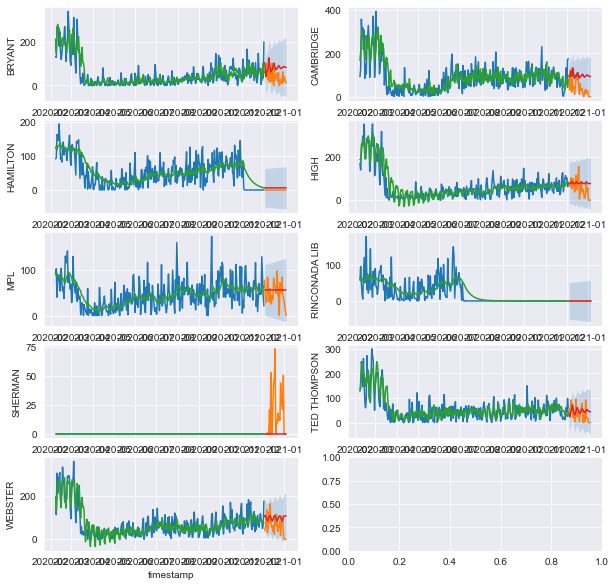

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
i = 0
j = 0
for col in data_columns:
    sns.lineplot(x = train_df.timestamp.iloc[-300:], y = train_df[col].iloc[-300:], ax=axs[i,j])
    sns.lineplot(x = test_df.timestamp, y = test_df[col], ax=axs[i,j])
    sns.lineplot(x = train_df.timestamp.iloc[-300:], y = fit_df[col].iloc[-300:], ax=axs[i,j])
    sns.lineplot(x = test_df.timestamp, y = forecast_df[col], ax=axs[i,j])
    axs[i,j].fill_between(test_df.timestamp, lower_df[col], upper_df[col], alpha=0.2)
    j += 1
    if j >= 2:
        i += 1
        j = 0

In [15]:
forecast_df.head(10)

,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA LIB,SHERMAN,TED THOMPSON,WEBSTER
3415,105.679287,94.928057,5.745936,78.812803,55.723783,0.000014,0.0,34.382297,104.099068
3416,80.822769,91.895480,6.285186,76.412221,55.723783,0.000014,0.0,22.442760,110.608189
3417,40.393378,109.933526,6.285186,76.455212,55.723783,0.000014,0.0,31.652893,97.381260
3418,62.714136,117.352260,6.285186,81.936947,55.723783,0.000014,0.0,46.251290,90.512106
3419,67.752147,92.473683,6.285186,85.647904,55.723783,0.000014,0.0,54.880065,84.733795
3420,76.813572,132.476882,6.285186,80.040077,55.723783,0.000014,0.0,72.368779,87.599502
3421,127.180238,130.788682,6.285186,75.567613,55.723783,0.000014,0.0,56.174694,103.066984
3422,101.825307,94.830361,6.285186,78.093541,55.723783,0.000014,0.0,40.187276,105.419784
3423,81.447810,84.043400,6.285186,75.941601,55.723783,0.000014,0.0,31.892059,109.308773
3424,62.641171,94.005448,6.285186,76.494682,55.723783,0.000014,0.0,36.149037,97.809857


In [16]:
test_df.head(10)

Normalized Station Name,timestamp,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA LIB,SHERMAN,TED THOMPSON,WEBSTER
3415,2020-12-04,60.486,100.294,0.0,66.232,76.958,0.0,0.000,57.462,40.620
3416,2020-12-05,59.134,30.598,0.0,63.027,38.770,0.0,0.000,34.155,51.143
3417,2020-12-06,93.695,124.283,0.0,76.074,28.275,0.0,0.000,38.832,77.703
3418,2020-12-07,100.885,85.664,0.0,102.500,29.239,0.0,0.000,92.359,136.385
3419,2020-12-08,46.871,20.897,0.0,53.272,83.444,0.0,0.000,75.471,30.477
3420,2020-12-09,27.928,82.647,0.0,59.503,78.989,0.0,1.778,66.646,50.660
3421,2020-12-10,87.603,36.147,0.0,99.182,30.304,0.0,0.000,19.867,124.223
3422,2020-12-11,16.117,45.685,0.0,84.770,54.718,0.0,20.852,33.687,74.985
3423,2020-12-12,65.558,10.815,0.0,36.880,58.585,0.0,0.000,29.143,163.241
3424,2020-12-13,31.562,39.852,0.0,50.474,25.149,0.0,53.063,3.731,81.625
